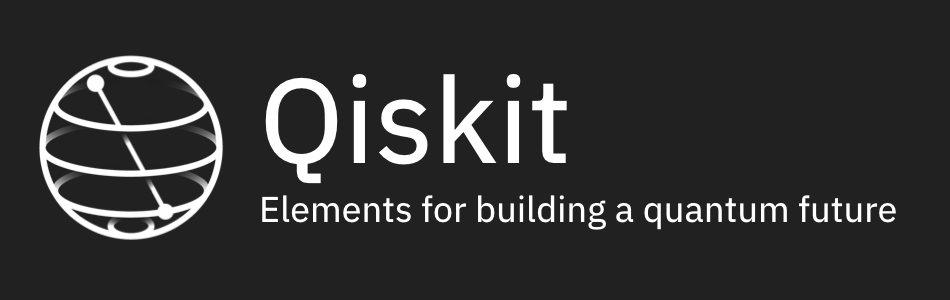

# Qiskit Aer: Noise Transformation

The latest version of this notebook is available on https://github.com/Qiskit/qiskit-iqx-tutorials.

## Introduction

This notebook shows how to use the Qiskit Aer `noise.utils.approximate_quantum_error` and `noise.utils. approximate_noise_model` to transform quantum noise channels into a different, more suitable, noise channel.

Our guiding example is Clifford simulation. A Clifford simulator can efficiently simulate quantum computations which include gates only from a limited, non-universal set of gates (the Clifford gates). Not all quantum noises can be added to such simulations; hence, we aim to find a "close" noise channel which can be simulated in a Clifford simulator.

We begin by importing the transformation functions.

In [1]:
from qiskit.providers.aer.noise.utils import approximate_quantum_error
from qiskit.providers.aer.noise.utils import approximate_noise_model

The name "approximate" suggests that these functions generate the closest (in the Hilbert-Schmidt metric) error possible to the given one.

We demonstrate the approximation using several standard error channels defined in Qiskit.

In [2]:
from qiskit.providers.aer.noise.errors.standard_errors import amplitude_damping_error
from qiskit.providers.aer.noise.errors.standard_errors import reset_error
from qiskit.providers.aer.noise.errors.standard_errors import pauli_error

In [3]:
import numpy as np

## Overview

A 1-qubit quantum channel is a function $\mathcal{C}:\mathbb{C}^{2\times2}\to\mathbb{C}^{2\times2}$ mapping density operators to density operators (to ensure the image is a density operator $\mathcal{C}$ is required to be completely positive and trace preserving, **CPTP**).

Given quantum channels $\mathcal{E}_{1},\dots,\mathcal{E}_{r}$, and probabilities $p_1, p_2, \dots, p_r$ such that $0\le p_i \le 1$ and $p_1+\dots +p_r = 1$, a new quantum channel $\mathcal{C}_\mathcal{E}$ can be constructed such that $\mathcal{C}_\mathcal{E}(\rho)$ has the effect of choosing the channel $\mathcal{E}_i$ with probability $p_i$ and applying it to $\rho$.

The noise transformation module solves the following optimization problem: Given a channel $\mathcal{C}$ ("goal") and a list of channels $\mathcal{E}_{1},\dots,\mathcal{E}_{r}$, find the probabilities $p_1, p_2, \dots, p_r$ minimizing $D(\mathcal{C}, \mathcal{C}_\mathcal{E})$ according to some distance metric $D$ (the Hilbert-Schmidt metric is currently used).

To ensure the approximation is honest, in the sense that the approximate error channel serves as an "upper bound" for the actual error channel, we add the additional honesty constraint:

$$\text{F}(I,\mathcal{C})\ge F(I,\mathcal{C}_\mathcal{E})$$

Where $\text{F}$ is a fidelity measure and $I$ is the identity channel.

## Example: Approximating amplitude damping noise with reset noise.

**Amplitude damping** noise is described by a single parameter $0\le \gamma \le 1$ and given by the Kraus operators:

$$\left(\begin{array}{cc}
1 & 0\\
0 & \sqrt{1-\gamma}
\end{array}\right),\left(\begin{array}{cc}
0 & \sqrt{\gamma}\\
0 & 0
\end{array}\right)$$

**Reset** error is described by probabilities $0\le p, q\le 1$ such that $p+q\le 1$ and given by the Kraus operators:

$$\left(\begin{array}{cc}
\sqrt{p} & 0\\
0 & 0
\end{array}\right),\left(\begin{array}{cc}
0 & \sqrt{p}\\
0 & 0
\end{array}\right),\left(\begin{array}{cc}
0 & 0\\
\sqrt{q} & 0
\end{array}\right),\left(\begin{array}{cc}
0 & 0\\
0 & \sqrt{q}
\end{array}\right)$$

This can be thought of as "resetting" the quantum state of the affected qubit to $\left|0\right\rangle$ with probability $p$, to $\left|1\right\rangle$ with probability $q$, and do nothing with probability $1-(p+q)$.

It is not too difficult to determine analytically the best values of $p,q$ to approximate a $\gamma$ amplitude damping channel, see the details __[here](https://arxiv.org/abs/1207.0046)__. The best approximation is:

$$p=\frac{1}{2}\left(1+\gamma-\sqrt{1-\gamma}\right), q=0$$

In [4]:
gamma = 0.23
error = amplitude_damping_error(gamma)
results = approximate_quantum_error(error, operator_string="reset")

We only needed the above code to perform the actual approximation. 

In [5]:
print(results)

p = (1 + gamma - np.sqrt(1 - gamma)) / 2
q = 0

print("")
print("Expected results:")
print("P(0) = {}".format(1-(p+q)))
print("P(1) = {}".format(p))
print("P(2) = {}".format(q))

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.8237482193044625, QasmQobjInstructions = [[{'name': 'id', 'qubits': [0]}]
  P(1) = 0.17625178069553749, QasmQobjInstructions = [[{'name': 'reset', 'qubits': [0]}]

Expected results:
P(0) = 0.8237482193696062
P(1) = 0.17625178063039387
P(2) = 0


We got the results predicted analytically.

## Different input types

The approximation function is given two inputs: The error channel to approximate, and a set of error channels that can be used in constructing the approximation.

The **error channel** to approximate can be given as any input that can be converted to the `QuantumError` object. 

As an example, we explicitly construct the Kraus matrices of amplitude damping and pass to the same approximation function as before:

In [6]:
gamma = 0.23
K0 = np.array([[1,0],[0,np.sqrt(1-gamma)]])
K1 = np.array([[0,np.sqrt(gamma)],[0,0]])
results = approximate_quantum_error((K0, K1), operator_string="reset")
print(results)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.8237482193044626, QasmQobjInstructions = [[{'name': 'id', 'qubits': [0]}]
  P(1) = 0.1762517806955374, QasmQobjInstructions = [[{'name': 'reset', 'qubits': [0]}]


The **error operators** that are used to construct the approximating channel can be either given as a list, a dictionary or a string indicating hard-coded channels. 

Any channel can be either a list of Kraus operators, or 'QuantumError' objects.

The identity channel does not need to be passed directly; it is always implicitly used.

As an example, we approximate amplitude damping using an explicit Kraus representation for reset noises:

In [7]:
reset_to_0 = [np.array([[1,0],[0,0]]), np.array([[0,1],[0,0]])]
reset_to_1 = [np.array([[0,0],[1,0]]), np.array([[0,0],[0,1]])]
reset_kraus = (reset_to_0, reset_to_1)

gamma = 0.23
error = amplitude_damping_error(gamma)
results = approximate_quantum_error(error, operator_list=reset_kraus)
print(results)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.8237482193044625, QasmQobjInstructions = [[{'name': 'id', 'qubits': [0]}]
  P(1) = 0.17625178069553749, QasmQobjInstructions = [[{'name': 'kraus', 'qubits': [0], 'params': [array([[1, 0],
       [0, 0]]), array([[0, 1],
       [0, 0]])], 'param': [array([[0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j]]), array([[1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j]])]}]


Note the difference in the output channel: The probabilities are the same, but the input Kraus operators were converted to general Kraus channels, which cannot be used in a Clifford simulator. Hence, it is always better to pass a `QuantumError` object instead of the Kraus matrices, when possible.

In [8]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright